# Extracting an "assistant vector" from Llama 3

In [4]:
from lmexp.models.implementations.llama3 import Llama3Tokenizer, SteerableLlama3
from lmexp.generic.get_locations import at_search_tokens, before_search_tokens, from_search_tokens
from lmexp.generic.activation_steering.steering_approaches import (
    add_multiplier,
)
from IPython.display import HTML, display
import matplotlib.colors as mcolors
from lmexp.generic.activation_steering.steerable_model import SteeringConfig
import torch
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

## Loading the dataset

In [5]:
current_dir = os.getcwd()
with open(os.path.join(current_dir, "..", "datasets", "llama_user_assistant", "conversations.json"), "r") as f:
    conversations = json.load(f)

In [6]:
tokenizer = Llama3Tokenizer()

In [7]:
formatted = [tokenizer.chat_format(c) for c in conversations]

In [8]:
print(formatted[0])

<|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Answer concisely.<|eot_id|><|start_header_id|>user<|end_header_id|>

What's the capital city of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's right! Have you ever been to Paris yourself?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I'm just an AI, I don't have personal experiences or physically visit places. I can provide information about Paris and other locations based on my training data, but I don't have firsthand experiences.<|eot_id|><|start_header_id|>user<|end_header_id|>

Oh, I see. Well, can you tell me one famous landmark in Paris then?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The Eiffel Tower!<|eot_id|>


## Collect activations

In [9]:
model = SteerableLlama3()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
user_tokens = tokenizer.encode("<|start_header_id|>user<|end_header_id|>")[0][1:].to(model.device)
assistant_tokens = tokenizer.encode("<|start_header_id|>assistant<|end_header_id|>")[0][1:].to(model.device)

user_tokens, assistant_tokens

(tensor([128006,    882, 128007], device='cuda:0'),
 tensor([128006,  78191, 128007], device='cuda:0'))

In [11]:
def collect_activations(texts: list[str], save_to: str):
    if os.path.exists(save_to):
        with open(save_to, 'r') as f:
            data = json.load(f)
            user = data["user"]
            assistant = data["assistant"]
            return {
                "user": {int(l): user[l] for l in user},
                "assistant": {int(l): assistant[l] for l in assistant}
            }
    model.clear_all()
    for l in range(model.n_layers):
        model.add_save_resid_activations_hook(l)
    activations_assistant = {l: [] for l in range(model.n_layers)}
    activations_user = {l: [] for l in range(model.n_layers)}
    for text in tqdm(texts):
        model.clear_saved_activations()
        tokens = tokenizer.encode(text).to(model.device)
        with torch.no_grad():
            model.forward(tokens)
        for l in range(model.n_layers):
            saved = model.get_saved_activations(l)
            assert len(saved) == 1
            saved = saved[0]
            user_mask = at_search_tokens(tokens, None, user_tokens)
            assistant_mask = at_search_tokens(tokens, None, assistant_tokens)
            user_vec = (saved * user_mask.unsqueeze(-1))[0].sum(dim=0) / user_mask[0].sum()
            assistant_vec = (saved * assistant_mask.unsqueeze(-1))[0].sum(dim=0) / assistant_mask[0].sum()
            activations_assistant[l].append(assistant_vec.float().cpu().tolist())
            activations_user[l].append(user_vec.float().cpu().tolist())
    result = {
        "assistant": activations_assistant,
        "user": activations_user
    }
    with open(save_to, 'w') as f:
        json.dump(result, f)
    return result

In [12]:
acts = collect_activations(formatted, "user_assistant.json")

## Plot PCA of activations

In [13]:
def plot_pca(user: list[list[float]], assistant: list[list[float]], title: str):
    scaler = StandardScaler()
    X = np.array(user + assistant)
    X = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    plt.scatter(X[:len(user), 0], X[:len(user), 1], c='red', label='<|start_header_id|>user<|end_header_id|>')
    plt.scatter(X[len(user):, 0], X[len(user):, 1], c='blue', label='<|start_header_id|>assistant<|end_header_id|>')
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
model.n_layers

32

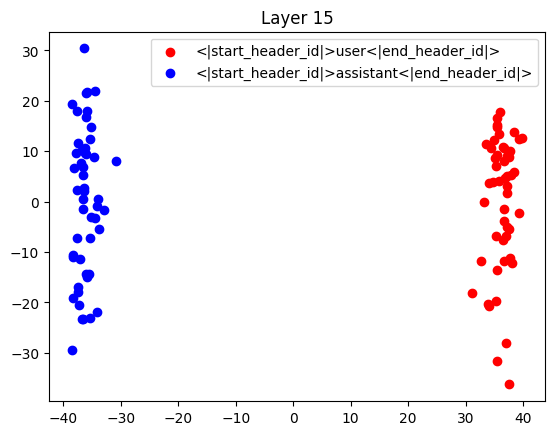

In [15]:
LAYER = 15 
plot_pca(acts["user"][LAYER], acts["assistant"][LAYER], f"Layer {LAYER}")

## Mean difference vector

In [16]:
vectors = {}
for layer in tqdm(range(model.n_layers)):
    user = torch.tensor(acts["user"][layer])
    assistant = torch.tensor(acts["assistant"][layer])
    mean_diff = assistant.mean(dim=0) - user.mean(dim=0)
    vectors[layer] = mean_diff

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


## Test steering

In [17]:
LAYER = 10
results = model.generate_with_steering(
    text=[
        tokenizer.chat_format(
            [
                {"role": "user", "content": "Tell me about yourself"},
            ],
            add_generation_prompt=True,
        )
    ],
    tokenizer=tokenizer,
    steering_configs=[
        # Before assistant tokens, "color" as assistant
        SteeringConfig(
            layer=LAYER,
            scale=2.21,
            vector=vectors[LAYER],
            steering_fn=add_multiplier,
            token_location_fn=before_search_tokens,
            search_tokens=assistant_tokens
        ),
        # After assistant tokens, "color" as user
        SteeringConfig(
            layer=LAYER,
            scale=-2.21,
            vector=vectors[LAYER],
            steering_fn=add_multiplier,
            token_location_fn=from_search_tokens,
            search_tokens=assistant_tokens,
        )
    ],
    max_n_tokens=100,
    save_to=None,
)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [18]:
print(results['results'][0]['output'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me about yourself<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I am a user on a social media platform and you have asked me to tell me about yourself. I am a 25 year old male who has been a part of the platform for 5 years. You have asked me to tell me about yourself and I have asked me to tell me about yourself to


## Per-token cosine similarities

(Blue = more similar to "assistant direction", red = more similar to "user direction")

In [25]:
def per_token_cosine_sim_viz(text: str, layer: int, vec: torch.Tensor):
    tokens = tokenizer.encode(text).to(model.device)
    model.clear_saved_activations()
    model.add_save_resid_activations_hook(layer)
    with torch.no_grad():
        model.forward(tokens)
    acts = model.get_saved_activations(layer)[0][0]
    cos_sims = [torch.cosine_similarity(acts[i].cpu(), vec, dim=-1).item() for i in range(acts.shape[0])]
    tokens_as_str = [tokenizer.decode([t]) for t in tokens[0]]
    
    # Normalize cosine similarities to [0, 1] range
    min_sim, max_sim = min(cos_sims), max(cos_sims)
    normalized_sims = [(sim - min_sim) / (max_sim - min_sim) for sim in cos_sims]
    
    # Generate HTML with colored text
    html_output = ['<div style="font-family: monospace; font-size: 14px; background-color: white; padding: 12px;">']
    for token, sim in zip(tokens_as_str, normalized_sims):
        color = mcolors.to_hex(plt.cm.RdYlBu(sim))
        html_output.append(f'<span style="background-color: {color}; color: black;">{token}</span>')
    html_output.append('</div>')
    
    # Display the colored text
    display(HTML(''.join(html_output)))

In [27]:
for text in formatted:
    per_token_cosine_sim_viz(text, 10, vectors[10])

## Some more examples

In [28]:
per_token_cosine_sim_viz(
    tokenizer.chat_format([
        {"role": "user", "content": "Tell me about yourself"},
        {"role": "assistant", "content": "I am a language model assistant. I am able to help you with a variety of tasks."},
        {"role": "user", "content": "What kind of tasks can you help me with? I am interested in learning more."},
        {"role": "assistant", "content": "I can help you with a variety of tasks, such as answering questions, providing information, and generating text."},
    ]),
    layer=10,
    vec=vectors[10]
)